# Elaborar planos de linhas para análise sismica

A problemática da elaboração de um planos de linhas para levantamentos geofísicos consiste em criar linhas dentro de um polígono que equispaçadas com as inclinações matemáticas necessárias, e consequentemente suas linhas perpendiculares. No plano de linhas há muitas formas de se fazer isso, e portanto, devemos considerar todos os tipos de inputs possíveis, e suas problemáticas aqui será apresntado uma situação onde o dado está desordenado e como faze-lo.

As bibliotecas necessárias serão apresentadas abaixo:

* Geopandas - dispensa explicações, um dataframe com a parte de geoprocessamento
* numpy - pra fazer conta
* matplotlib - pra plotar
* shapely.geometry - pra crar as geometrias que eu vou utilziar nesta bagaça
* os - oprações do sistema

In [5]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon,LineString,asLineString,MultiLineString
import os
# para que os plots fiquem dentro do notebook
%matplotlib inline

## Declaração de variáveis

Primeiramente vamos declarar as variáveis para que desta forma o script fique organizado:
* path - diretório onde os arquivos estão armazenados - A importância de declarar uma variável desta está relacionada com a organização do fluxo de trabalho, uma mera formalidade mas que quando criamos o script para entrar na produção é necessária
* fname - nome do arquivo com os dados. Neste caso estou trabalhando com um shape file de pontos.
* MajorAxis - espaçamento entre as linhas no maior eixo do plano de linhas
* MinorAxis - espaçamento entre as linhas no menor eixo do plano de linhas

In [6]:
# Para evitar alguns erros lembra que ou vc troca o \ por / ou por \\
# por convenção prefiro / por ser usuário de linux
path = 'dados/PoligonoPlanoDeLinhasSismica/'
# nome do shape
fname = 'Limites.shp'
# distância das linhas
MajorAxis=50
MinorAxis=30


## Organizar os dados

### Verificar os dados disponíveis

Aqui vamos dar uma primeira olhada nos dados, ver os atributos do arquivo, conferir se de fato é um shape de polígono e como estão dispostos estes polígonos

        X        Y                geometry
0  376056  7699770  POINT (376056 7699770)
1  376056  7700170  POINT (376056 7700170)
2  376560  7700170  POINT (376560 7700170)
3  376560  7699352  POINT (376560 7699352)
4  376216  7699352  POINT (376216 7699352)
5  376216  7700584  POINT (376216 7700584)


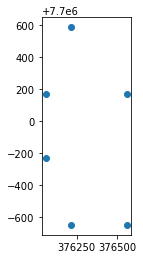

In [7]:
gdf = gpd.read_file(os.path.join(path,fname))
print(gdf)
# visualizar os dados
gdf.plot()

### Converter geometria e verificar o resultado

Sabendo que foi passado um resultado de pontos, e observando a tabela acima inferesse que os pontos não estão ordenados o que vai resultar em um polígono deformado, portanto primeiramente será feira uma conferencia dos pontos, aplicando um teste de geometria apenas por mera formalidade

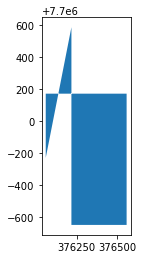

In [9]:
if not isinstance(gdf.geometry[0], Polygon):
    
    geometry=Polygon([[p.x, p.y] for p in gdf.geometry])
    area=gpd.GeoDataFrame(['area'],geometry=[geometry],crs=gdf.crs)
    
else:
    area=gdf
    
area.plot()

### Ordenação dos resultados
    
Neste momento deve-se ordenar os resutados, para tal devemos seguir um procedimento, aqui partirei do resultado de polígono pois é interessante que eu o algoritimo seja feito para polígonos assim pode ser colocado em produção

0. Pegar as coordenadas
1. Calcular o ponto central do polígono
2. Plotar o resultado com o ponto central para verificação
3. Calcular o arco tangente para ter a localização geométrica (e relativa) dos pontos
4. Ordenar pelo resultado do arco tangente ao ponto
5. Criar um novo polígono
6. Plotar resultado
    
    

In [18]:
# 1
# obter os valoes de x e y
x,y = geometry.exterior.coords.xy
# 2
# calcular os centros
xc = np.mean(x)
yc = np.mean(y)
# 3
# ver se o centro é centro mesmo
area.plot()
plt.plot(xc,yc,'rx')
# 4
# valores para arco tangente
xt=np.asarray(x)-xc
yt=np.asarray(y)-yc
gdf['sorter'] = np.arctan2(yt[:-1],xt[:-1])
# 5
ngdf = gdf.sort_values('sorter')
# 6
geometry=Polygon([[p.x, p.y] for p in ngdf.geometry])
area=gpd.GeoDataFrame(['area'],geometry=[geometry],crs=gdf.crs)
# 7
area.plot()

AttributeError: 'list' object has no attribute 'exterior'

Ordenação resolvida
 

## Calcular a maior linha dentro do polígono e sua intersecção

Calcular as linhas base para o plano de linhas, primeiramente vamos encontrar a maior linha possível (já que foi fornecido apenas o polígono base), desta forma o plano de linhas cobrirá o maior espaço da área.
Para desenhar esta linha utilizaremos o ponto mais distante do centro do polígono, em seguida, traçaremos a linha do centro até este ponto mais distante e recorto ela na área do polígono.
Em seguida rotaciono a linah 90 graus e recorto ela, e assim tenho a linah perpendicular.

Em programação o procedimento é o seguinte:

0. Pegar o ponto central e pontos do perímetro do polígono
1. Calcular as distâncias entre os pontos (raiz de x^2+y^2)
2. Pegar o índice da maior distância
3. Criar uma linha no geodataframe usando a maior distancia (posotiva e negativamente)
4. Recortar a linha apenas para os limites dentro do polígono
5. Através do centroíde da linha, rotaciona-la 90 graus, para isso:

    x = dx * cos(theta) - dy * sin(theta) + xcentro
    y = dx * sin(theta) + dy * cos(theta) + ycentro

    simplificado (theta =90 então cos =0 e sin =1) ficou

    x = - dy + xcentro
    y = dx  + ycentro

6. Repetir o processo 3 e 4 para a linha rotacionada
7. Plotar

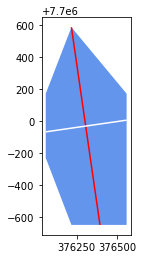

In [19]:
# 1
xc = area.centroid.x[0]
yc = area.centroid.y[0]

coords = area.geometry.apply(lambda x:x.exterior.coords.xy)
x,y = coords.values[0]
# 2
distance = ((np.asarray(x)-xc)**2+(np.asarray(y)-yc)**2)**0.5
#3
ind = np.argmax(distance)

dx = x[ind]-xc
dy = y[ind]-yc
#4
line = LineString(
    [(xc-dx,yc-dy),
    (xc+dx,yc+dy)]
)

line = gpd.GeoDataFrame(['main'],geometry=[line],crs=gdf.crs)
#5
line = area.intersection(line)
#6
xLineC = line.centroid.x
yLineC = line.centroid.y

minorX,minorY = line.geometry.values[0].coords.xy

newx = (-np.asarray(minorY) + yLineC.values)+xLineC.values
newy = (np.asarray(minorX) - xLineC.values)+yLineC.values
#7
minorLine = LineString([(xx,yy) for xx,yy in zip(newx,newy) ])
minorLine = gpd.GeoDataFrame(geometry=[minorLine],crs=gdf.crs)
minorLine = area.intersection(minorLine)
#8
ax = area.plot(color='cornflowerblue')
line.plot(ax=ax,color='red')
minorLine.plot(ax=ax,color='white')

## Criar as linhas equiespaçadas
    
Agora que as linhas principais foram criadas, criaremos as linhas equiespaçadas
    
1. Verifico qual a direção preferencial de cada uma das linhas (maior linha e sua perpendicular)
2. Crio o eixo com os valores do buffer
3. Crio a função que aplica o buffer via shapely (via geopandas a função tem limitaçoes que eu não gosto) e converte este buffer de polígono para linha
4. Cria o geodataframe todo com um Multi Poligono e depois intersecta
5. Faz a mesma coisa para a linha perpendicular
6. Plota

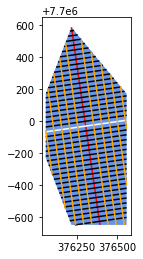

In [20]:
# 1
bnds = area.bounds

if dy>dx:
    N = np.ceil(len(np.arange(bnds['minx'],bnds['maxx'],MajorAxis))/2)
    M = np.ceil(len(np.arange(bnds['miny'],bnds['maxy'],MinorAxis))/2)
        
else:
    N = np.ceil(len(np.arange(bnds['miny'],bnds['maxy'],MajorAxis))/2)
    M = np.ceil(len(np.arange(bnds['minx'],bnds['maxx'],MinorAxis))/2)
# 2
buffers=np.arange(MajorAxis,N*MajorAxis,MajorAxis)
# 3
def LineBuffer(line,brange):

    nline = asLineString(line.geometry.values[0].buffer(brange,cap_style=3).exterior)
    
    return nline
# 4
geometry = [MultiLineString([LineBuffer(line,buf) for buf in buffers])]
lines = gpd.GeoDataFrame(geometry=geometry,crs=gdf.crs)
lines = area.intersection(lines)

# 5
Minorbuffers=np.arange(MinorAxis,M*MinorAxis,MinorAxis)

geometry = [MultiLineString([LineBuffer(minorLine,buf) for buf in Minorbuffers])]

minorLines = gpd.GeoDataFrame(geometry=geometry,crs=gdf.crs)
minorLines = area.intersection(minorLines)
#6
ax = area.plot(color='cornflowerblue')
line.plot(ax=ax,color='red')
minorLine.plot(color='white',ax=ax)
minorLines.plot(color='black',ax=ax)
lines.plot(ax=ax,color='orange')